# Huấn luyện mô hình với các activation khác nhau trên các hidden layers

Danh sách activation trên các hidden layers  : relu, leaky relu, elu, tanh,

## Import Libraries

In [1]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
import keras.backend as K
import random
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import multivariate_normal
from IPython import display

# Pernament Random

In [3]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

## Some Functions

In [4]:
def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data

def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)

    #train
    x_train, y_train = load_data(csv_train)

    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x.iloc[:,0], x.iloc[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def normalize_data(x_train, x_valid, x_test):
    x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv",
                                                                      csv_valid="./data/valid.csv",
                                                                      csv_test="./data/test.csv")
    v_mean, v_std = None, None

    # Visualize data
    print("*******************")
    print("Befor Normalization")
    print("*******************")
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))

    # Visualize data
    if v_mean is None and v_std is None: # Prevent normalization with many times
        v_mean = np.mean(x_train, axis = 0)
        v_std  = np.std(x_train, axis = 0)

        x_train = (x_train - v_mean) / v_std
        x_valid = (x_valid - v_mean) / v_std
        x_test  = (x_test - v_mean) / v_std
    # if
    print("\n\n")
    print("Mean = %s, Std = %s"%(str(v_mean), str(v_std)))

    print("*******************")
    print("After Normalization")
    print("*******************")
    print("Train min=%.3f, max=%.3f" % (x_train.min(), x_train.max()))
    print("Valid min=%.3f, max=%.3f" % (x_valid.min(), x_valid.max()))
    print("Test min=%.3f, max=%.3f" % (x_test.min(), x_test.max()))

    return x_train, x_valid, x_test
# build_data

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n", 
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"], 
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n", 
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np

    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for

    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if

    if is_show == True:
        plt.show()
        return None
    return fig
# visualize_logs

## 1. DATASET

<class 'pandas.core.frame.DataFrame'>
(100, 2)


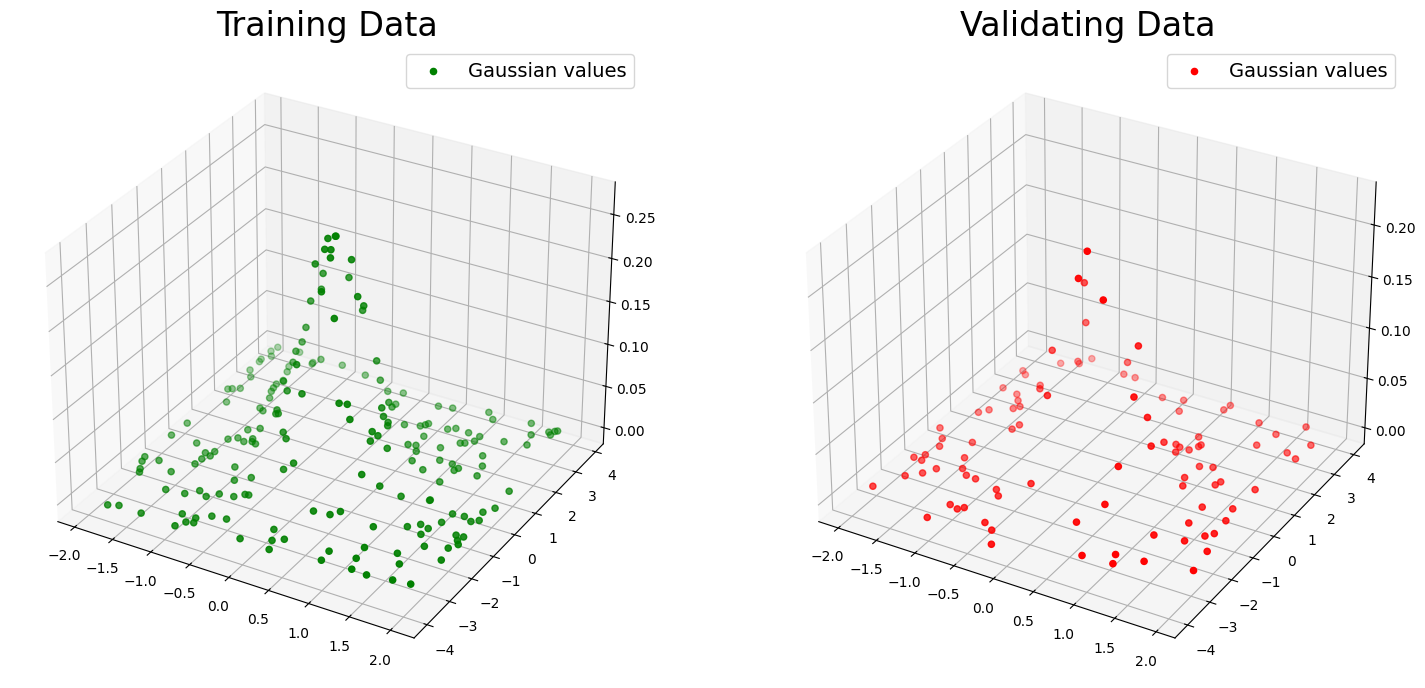

In [5]:
data_train = pd.read_csv("data/train.csv")
data_valid = pd.read_csv("data/valid.csv")
data_test = pd.read_csv("data/test.csv")

x_train, y_train = data_train[['x1', 'x2']], data_train['y']
x_valid, y_valid = data_valid[['x1', 'x2']], data_valid['y']
x_test, y_test = data_test[['x1', 'x2']], data_test['y']


x_exp1_train, y_exp1_train = x_train[:200], y_train[:200]
x_exp1_valid, y_exp1_valid = x_valid, y_valid

print(type(x_exp1_valid))
print(x_exp1_valid.shape if hasattr(x_exp1_valid, 'shape') else "No shape attribute")

# Tạo figure với kích thước lớn
plt.figure(figsize=(18, 10))
# Vẽ đồ thị 3D cho training data
ax1 = plt.subplot(1, 2, 1, projection='3d');
ax1.scatter(x_exp1_train.iloc[:, 0], x_exp1_train.iloc[:, 1], y_exp1_train, color='green')
ax1.set_title("Training Data", fontsize=24)
ax1.legend(["Gaussian values"], fontsize=14)

# Vẽ đồ thị 3D cho validating data
ax2 = plt.subplot(1, 2, 2, projection='3d')
ax2.scatter(x_exp1_valid.iloc[:, 0], x_exp1_valid.iloc[:, 1], y_exp1_valid, color='red')
ax2.set_title("Validating Data", fontsize=24)
ax2.legend(['Gaussian values'], fontsize=14);

plt.show()


## 2. NETWORK STRUCTURE

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(n_hidden_node = 10, n_hidden_layer = 1, hidden_activation = "relu"):
    inp = Input(shape=(2,), name='Input')
    for i in range(n_hidden_layer):
        if i == 0:
            x = Dense(units=n_hidden_node, activation=hidden_activation, name=f'h_{i}' + "-" + hidden_activation)(inp)
        else:
            x = Dense(units=n_hidden_node, activation=hidden_activation, name=f'h_{i}'  + "-" + hidden_activation)(x)
                                                                                             
    output_label = Dense(units=1, activation='linear', name='Output-linear')(x)

    model = Model(inputs=inp, outputs=output_label)
    model.summary()
    return model


## 3. EXPERIMENT 6:

### 3.1. Train Data

In [7]:
import json

with open('best_sample_size.json', 'r') as f:
    data = json.load(f)
best_sample_size = data["best_sample_size"]
print(f"Best sample size: {best_sample_size}")

Best sample size: 1400


Train: x-shape = (1400, 2) y-shape = (1400,)
Valid: x-shape = (100, 2) y-shape = (100,)


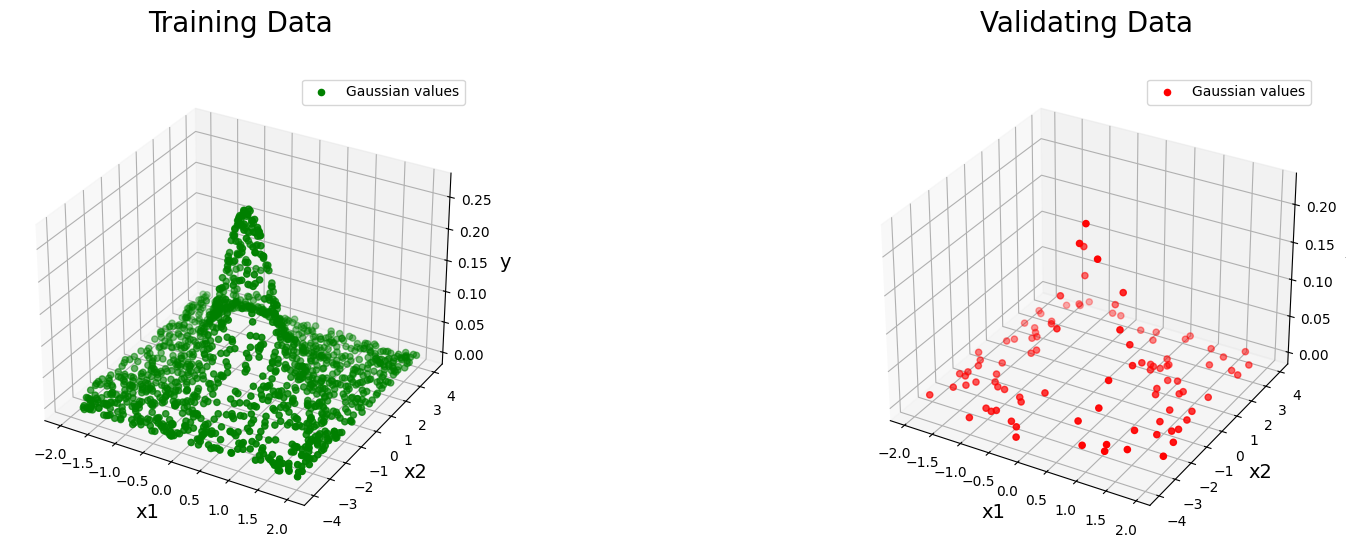

In [8]:
x_exp3_train, y_exp3_train = x_train[:best_sample_size], y_train[:best_sample_size]
x_exp3_valid, y_exp3_valid = x_valid, y_valid

print(f"Train: x-shape = {x_exp3_train.shape} y-shape = {y_exp3_train.shape}")
print(f"Valid: x-shape = {x_exp3_valid.shape} y-shape = {y_exp3_valid.shape}")

plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1,2,1, projection='3d')
visualize_dataset(x_exp3_train, y_exp3_train, color = "green", title = "Training Data\n", ax = ax1)

ax2 = plt.subplot(1,2,2, projection='3d')
visualize_dataset(x_exp3_valid, y_exp3_valid, color = "red", title = "Validating Data\n", ax = ax2)

### 3.2. Model

In [9]:
model = build_model(n_hidden_node=10, n_hidden_layer=4, hidden_activation="relu")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_0-relu (Dense)                │ (None, 10)             │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_1-relu (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_2-relu (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_3-relu (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-linear (Dense)           │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371 (1.45 KB)

 Trainable params: 371 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

### 3.3. Training

In [10]:
def train_model(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid, n_hidden_node = 10, n_hidden_layer = 1, hidden_activation = "relu", nb_epochs = 200):

    K.clear_session()
    exp3_model = build_model(n_hidden_node, n_hidden_layer, hidden_activation)

    # OPTIMIZATION
    exp3_model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

    # CALLBACKS
    callbacks = []

    # + ModelCheckPoint
    save_dir = f"./data/model/train_03/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    modekcheckpoint_callback = ModelCheckpoint(filepath = os.path.join(save_dir, template_name),
                                               monitor='val_loss',
                                               verbose=0,
                                               save_best_only=True,
                                               save_weights_only=False, # only weight, 
                                               mode='auto', # min, max, auto
                                               )
    callbacks.append(modekcheckpoint_callback)

    # + Early Stopping
    # earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
    # callbacks.append(earlystopping_callback)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                           "style": "median"},
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                           "style": None}
                          ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False,
                             save_path = os.path.join(f"./data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass
    # custom_on_epoch_end

    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks)

    # TRAINING
    batch_size = 128
    epochs = nb_epochs

    starting_time = time.time()
    history = exp3_model.fit(x_local_train, y_local_train,
                             validation_data=(x_local_valid, y_local_valid),
                             batch_size=batch_size,
                             epochs=epochs,
                             callbacks = callbacks,
                             verbose = 0)
    print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))
    return history


In [11]:
import json

with open('best_epoch.json', 'r') as f:
    data = json.load(f)
best_epoch = data["best_epoch"]
print(f"Best epoch: {best_epoch}")

with open('best_sample_size.json', 'r') as f:
    data = json.load(f)
best_sample_size = data["best_sample_size"]
print(f"Best sample size: {best_sample_size}")

with open('best_nhidden_node.json', 'r') as f:
    data = json.load(f)
best_hidden_node = data["best_nhidden_node"]
print(f"Best hidden nodes: {best_hidden_node}")

with open('best_hidden_layer.json', 'r') as f:
    data = json.load(f)
best_hidden_layer = data["best_hidden_layer"]
print(f"Best hidden layers: {best_hidden_layer}")

Best epoch: 156
Best sample size: 1400
Best hidden nodes: 13
Best hidden layers: 6


Train id: 0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_0-relu (Dense)                │ (None, 13)             │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_1-relu (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_2-relu (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_3-relu (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_4-relu (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_5-relu (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-linear (Dense)           │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

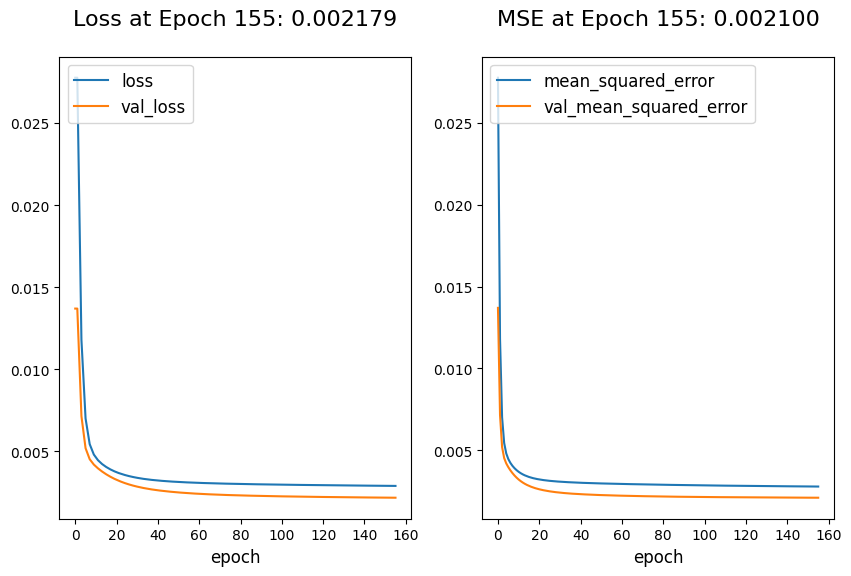

> training time is 0.8256 minutes
Train id: 1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_0-leaky_relu (Dense)          │ (None, 13)             │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_1-leaky_relu (Dense)          │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_2-leaky_relu (Dense)          │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_3-leaky_relu (Dense)          │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_4-leaky_relu (Dense)          │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_5-leaky_relu (Dense)          │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-linear (Dense)           │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

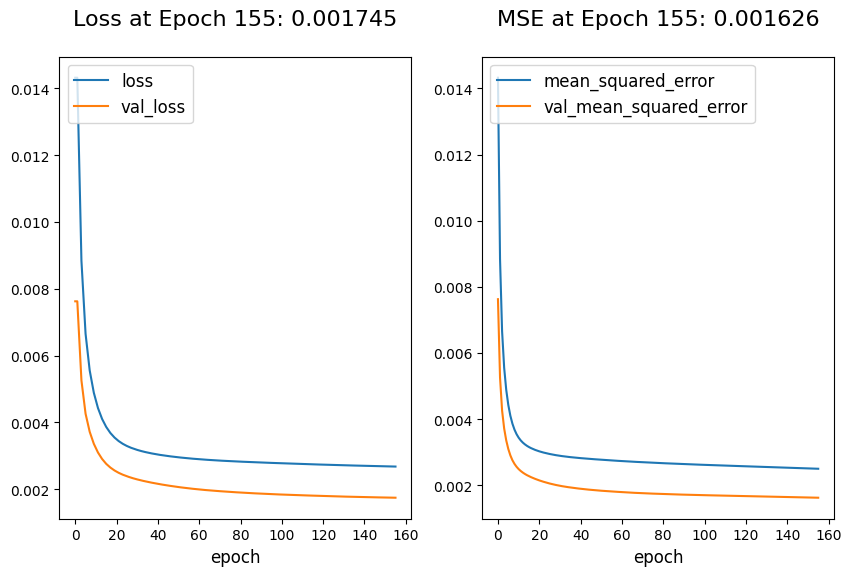

> training time is 0.8737 minutes
Train id: 2


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_0-elu (Dense)                 │ (None, 13)             │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_1-elu (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_2-elu (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_3-elu (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_4-elu (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_5-elu (Dense)                 │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-linear (Dense)           │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

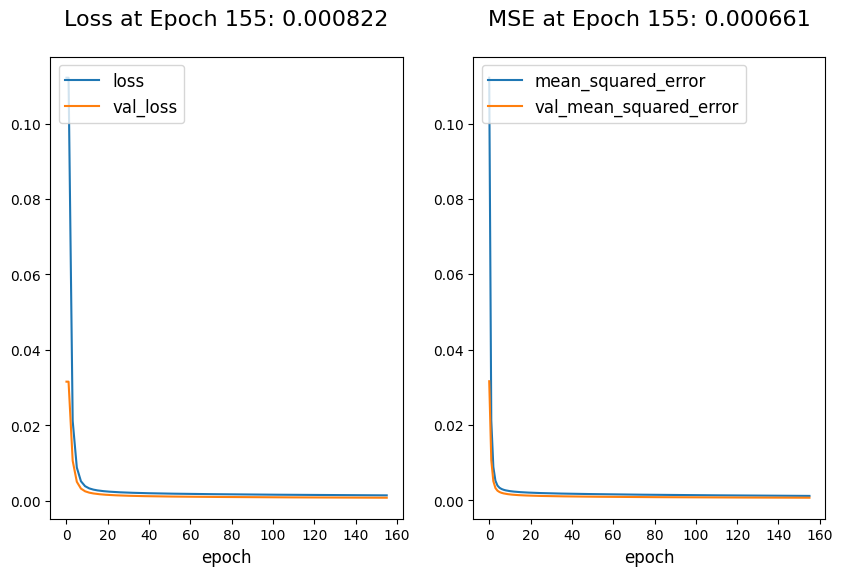

> training time is 0.8395 minutes
Train id: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_0-tanh (Dense)                │ (None, 13)             │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_1-tanh (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_2-tanh (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_3-tanh (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_4-tanh (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h_5-tanh (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output-linear (Dense)           │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963 (3.76 KB)

 Trainable params: 963 (3.76 KB)

 Non-trainable params: 0 (0.00 B)

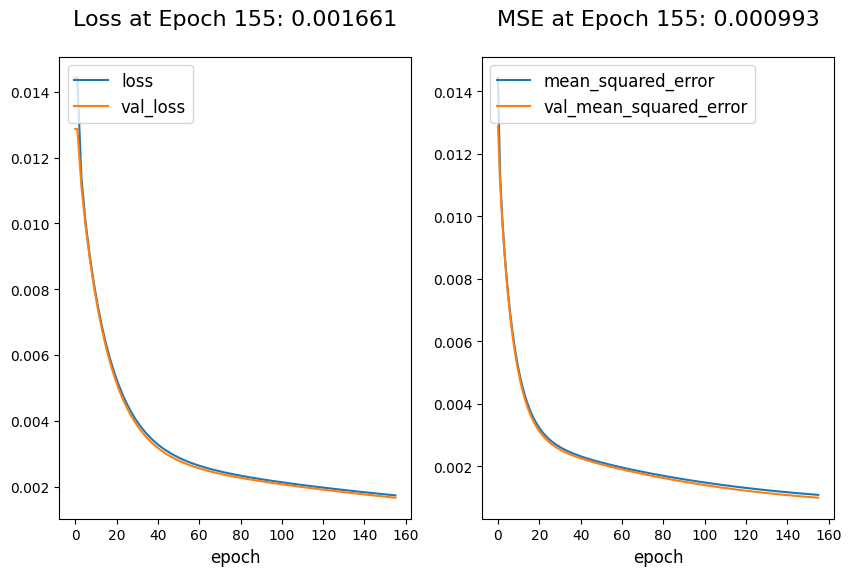

> training time is 0.8766 minutes


In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
activation_list = ["relu", "leaky_relu", "elu", "tanh"]

history = []
for i, activation in enumerate(activation_list):
    print(f"Train id: {i}")
    temp_history = train_model(i, x_exp3_train, y_exp3_train, x_exp3_valid, y_exp3_valid, n_hidden_node=best_hidden_node, n_hidden_layer=best_hidden_layer, hidden_activation=activation, nb_epochs = best_epoch)
    history.append(temp_history)

### 3.4. Evaluating

In [13]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
activation = ["relu", "leaky_relu", "elu", "tanh"]
errors

[0.0020998441614210606,
 0.001626337063498795,
 0.0006613375153392553,
 0.0009934367844834924]

In [14]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at activation={activation[vt_min]} with error = {errors[vt_min]}")

Min Error at activation=elu with error = 0.0006613375153392553


Text(0.5, 1.0, 'performance against the activation functions\n')

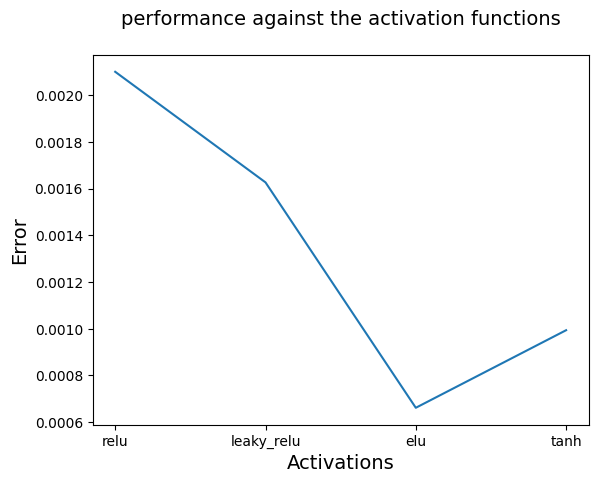

In [15]:
plt.plot(activation, errors)
plt.xlabel("Activations", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("performance against the activation functions\n", fontsize = 14)

### 3.5 Nhận xét

* Activation function elu cho kết quả tốt nhất với error = 0.00031150042195804417
* Các activation relu, leaky_rely, elu vẫn chưa đạt điểm bão hòa, cần thêm thời gian (thêm epoch) để huấn luyện.